In [1]:
import z3
import json
import pprint
import numpy as np
import pandas as pd

with open ('simple.json') as file:
    data = json.load(file)

#------------SETUP-------------------------------

# List of Resource Types
resourceTypes = set([j for i in data for j in data[i]['resources'] ])

# Initialize data structures
nodeList = list()
appList = list()
nlappList = list() # List of apps that are dependencies
prAppList = list() # List of primary apps that have dependencies
a2a = []
n2n = []

# Node and App lists
for i in data:
    if data[i]['type']=='node':
        nodeList.append(i)
    if data[i]['type']=='app':
        appList.append(i)
        if data[i]['dependencies']['nonlocal']:
            prAppList.append(i)
            for dep in data[i]['dependencies']['nonlocal']:
                nlappList.append(dep)
print("Dependency apps: %s" %(nlappList))
print("Primary apps: %s" %(prAppList))
# app to app dependency matrix            
for app in appList:
    nl_deps = data[app]['dependencies']['nonlocal']
    deps = []
    for dep in appList:
        if dep in nl_deps:
            deps.append(1)
        else: 
            deps.append(0)
    a2a.append(deps)
a2a_df = pd.DataFrame(a2a, index=appList, columns=appList)        

# node to node latency matrix
n2n = []
for node in nodeList:
    id = data[node]['id']
    temp = []    
    for n2 in nodeList:
        id2 = data[n2]['id']
        lat = data[node]['latencies']['n%s%s' %(id, id2)]
        temp.append(lat)
    n2n.append(temp)
n2n_df = pd.DataFrame(n2n, index=nodeList, columns=nodeList)  

# node resource matrix
rpn= [[data[j]['resources'][k] for j in nodeList] for k in resourceTypes]
rpn_df = pd.DataFrame(rpn, index=resourceTypes, columns=nodeList)     
    
# app resource matrix
rpa= [[data[i]['resources'][k] for i in appList] for k in resourceTypes]
rpa_df = pd.DataFrame(rpa, index=resourceTypes, columns=appList)    
print(rpa_df.loc['memory', 'APP1'])
print(type(rpa_df.loc['memory', 'APP1']))

# app to node placment matrix
a2n = [ [ z3.Real("a%s%s" % (i+1, j+1)) for j in range(len(nodeList)) ]
            for i in range(len(appList))]
a2n_df = pd.DataFrame(a2n, index=appList, columns=nodeList) 

print("n2n: \n%s" %n2n_df)
print("a2a: \n%s" %a2a_df)
print("rpn: \n%s" %rpn_df)
print("rpa: \n%s" %rpa_df)

print("a2n: \n%s" %a2n_df)

Dependency apps: ['APP2']
Primary apps: ['APP1']
256
<class 'numpy.int64'>
n2n: 
       FSSN3  FSSN2  FSSN4  FSSN1  FSSN5
FSSN3      0      5      7      4      8
FSSN2      5      0      6      3      7
FSSN4      7      6      0      5      9
FSSN1      4      3      5      0      6
FSSN5      8      7      9      6      0
a2a: 
      APP1  APP2
APP1     0     1
APP2     0     0
rpn: 
        FSSN3  FSSN2  FSSN4  FSSN1  FSSN5
memory    512    512    512   1024    512
rpa: 
        APP1  APP2
memory   256   128
a2n: 
     FSSN3 FSSN2 FSSN4 FSSN1 FSSN5
APP1   a11   a12   a13   a14   a15
APP2   a21   a22   a23   a24   a25


In [2]:
a2n_df

,FSSN3,FSSN2,FSSN4,FSSN1,FSSN5
APP1,a11,a12,a13,a14,a15
APP2,a21,a22,a23,a24,a25


In [3]:
n2n_df

,FSSN3,FSSN2,FSSN4,FSSN1,FSSN5
FSSN3,0,5,7,4,8
FSSN2,5,0,6,3,7
FSSN4,7,6,0,5,9
FSSN1,4,3,5,0,6
FSSN5,8,7,9,6,0


In [4]:
a2a_df

,APP1,APP2
APP1,0,1
APP2,0,0


In [5]:
rpn_df

,FSSN3,FSSN2,FSSN4,FSSN1,FSSN5
memory,512,512,512,1024,512


In [6]:
rpa_df

,APP1,APP2
memory,256,128


In [7]:
#------------Constraints-------------------------------
# variables in a2n matrix must be binary

a2n_domain = [z3.Or(a2n_df.loc[app, node]==0, a2n_df.loc[app, node]==1) \
 for app in nlappList \
 for node in nodeList]

# An intial deployment of apps that have dependencies
a2n_df.loc['APP1'] = 1
#a2n_df.loc['APP1', 'FSSN2'] = 1
#a2n_df.loc['APP1', 'FSSN3'] = 1
print (a2n_df)
a2n_domain


     FSSN3 FSSN2 FSSN4 FSSN1 FSSN5
APP1     1     1     1     1     1
APP2   a21   a22   a23   a24   a25


[Or(a21 == 0, a21 == 1),
 Or(a22 == 0, a22 == 1),
 Or(a23 == 0, a23 == 1),
 Or(a24 == 0, a24 == 1),
 Or(a25 == 0, a25 == 1)]

In [8]:
# Max capacity constraint
# Resources required by apps deployed on a node cannot exceed that nodes resources
app_util = rpa_df.dot(a2n_df)
print(app_util)
node_util = rpn_df - app_util
print(node_util)
rsrc_constraint = [node_util.loc[rsrc,node]>=0 \
                   for rsrc in resourceTypes \
                   for node in nodeList]
rsrc_constraint

                FSSN3          FSSN2          FSSN4          FSSN1  \
memory  256 + 128*a21  256 + 128*a22  256 + 128*a23  256 + 128*a24   

                FSSN5  
memory  256 + 128*a25  
                        FSSN3                  FSSN2                  FSSN4  \
memory  512 - (256 + 128*a21)  512 - (256 + 128*a22)  512 - (256 + 128*a23)   

                         FSSN1                  FSSN5  
memory  1024 - (256 + 128*a24)  512 - (256 + 128*a25)  


[512 - (256 + 128*a21) >= 0,
 512 - (256 + 128*a22) >= 0,
 512 - (256 + 128*a23) >= 0,
 1024 - (256 + 128*a24) >= 0,
 512 - (256 + 128*a25) >= 0]

In [9]:
# Must Deploy Dependencies constraint
# Assuming the primary app is deployed, all of it's dependencies must be deployed
mdd = [a2n_df.loc[dep].sum() > 0 for dep in nlappList]
mdd

[a21 + a22 + a23 + a24 + a25 > 0]

In [10]:
print([n2n_df.loc[src,dst] for src in nodeList for dst in nodeList])

[0, 5, 7, 4, 8, 5, 0, 6, 3, 7, 7, 6, 0, 5, 9, 4, 3, 5, 0, 6, 8, 7, 9, 6, 0]


In [11]:
n2n_df

,FSSN3,FSSN2,FSSN4,FSSN1,FSSN5
FSSN3,0,5,7,4,8
FSSN2,5,0,6,3,7
FSSN4,7,6,0,5,9
FSSN1,4,3,5,0,6
FSSN5,8,7,9,6,0


In [12]:
# Latency 
numNodes = len(nodeList) # number of FSSNs
markings = list() # The equations for each possible placement of the dependencies

for srcNode in nodeList:
    print (srcNode)
    for prApp in prAppList:
        if a2n_df.loc[app, srcNode] == 1:            
            ### ITERATE THROUGH ALL DEPENDENCIES
            # iterate through the 2^numNodes potential dependency placements
            for i in range(2**numNodes):
                mark = format(i, 'b').zfill(numNodes) # express placment in binary    
                #print(mark)
                #if dependency is not placed skip.
                if mark == format(0,'b').zfill(numNodes):
                    continue

                marking = list() # A placment equation e.g (1 - a11)*(1 - a12)*a13
                latency = [] # latencies between node hosting primary app and all nodes hosting the dependency for a particular placement. 
                print ("-----NEW MARKING-----")
                # iterate through nodes using the binary placement to generate marking equation
                for i, node in enumerate(nodeList):
                    #print ("mark %s" %mark)
                    #print ("i %s " %i)
                    #print ("mark[i] %s" %type(int(mark[i]))) 
                    # add marking to list and if binary has a 1, add latency to list of possible latencies
                    if int(mark[i]) == 1:
                        marking.append(a2n_df.loc['APP2', node])
                        latency.append(n2n_df.loc[srcNode, node])
                    if int(mark[i]) == 0:
                        marking.append(1 - a2n_df.loc['APP2',node])
                print("latency %s" %latency)
                print("min latency %s" %min(latency))
                print("marking: %s" %marking)
                print("marking * latency: %s" %(z3.Product(marking) * min(latency).item()))
                markings.append(z3.Product(marking) * min(latency).item())

print(markings)
latency_obj = z3.Sum(markings)
pprint.pprint(latency_obj)

    



FSSN3
-----NEW MARKING-----
latency [8]
min latency 8
marking: [1 - a21, 1 - a22, 1 - a23, 1 - a24, a25]
marking * latency: (1 - a21)*(1 - a22)*(1 - a23)*(1 - a24)*a25*8
-----NEW MARKING-----
latency [4]
min latency 4
marking: [1 - a21, 1 - a22, 1 - a23, a24, 1 - a25]
marking * latency: (1 - a21)*(1 - a22)*(1 - a23)*a24*(1 - a25)*4
-----NEW MARKING-----
latency [4, 8]
min latency 4
marking: [1 - a21, 1 - a22, 1 - a23, a24, a25]
marking * latency: (1 - a21)*(1 - a22)*(1 - a23)*a24*a25*4
-----NEW MARKING-----
latency [7]
min latency 7
marking: [1 - a21, 1 - a22, a23, 1 - a24, 1 - a25]
marking * latency: (1 - a21)*(1 - a22)*a23*(1 - a24)*(1 - a25)*7
-----NEW MARKING-----
latency [7, 8]
min latency 7
marking: [1 - a21, 1 - a22, a23, 1 - a24, a25]
marking * latency: (1 - a21)*(1 - a22)*a23*(1 - a24)*a25*7
-----NEW MARKING-----
latency [7, 4]
min latency 4
marking: [1 - a21, 1 - a22, a23, a24, 1 - a25]
marking * latency: (1 - a21)*(1 - a22)*a23*a24*(1 - a25)*4
-----NEW MARKING-----
latency [

marking: [a21, a22, 1 - a23, a24, 1 - a25]
marking * latency: a21*a22*(1 - a23)*a24*(1 - a25)*0
-----NEW MARKING-----
latency [5, 0, 3, 7]
min latency 0
marking: [a21, a22, 1 - a23, a24, a25]
marking * latency: a21*a22*(1 - a23)*a24*a25*0
-----NEW MARKING-----
latency [5, 0, 6]
min latency 0
marking: [a21, a22, a23, 1 - a24, 1 - a25]
marking * latency: a21*a22*a23*(1 - a24)*(1 - a25)*0
-----NEW MARKING-----
latency [5, 0, 6, 7]
min latency 0
marking: [a21, a22, a23, 1 - a24, a25]
marking * latency: a21*a22*a23*(1 - a24)*a25*0
-----NEW MARKING-----
latency [5, 0, 6, 3]
min latency 0
marking: [a21, a22, a23, a24, 1 - a25]
marking * latency: a21*a22*a23*a24*(1 - a25)*0
-----NEW MARKING-----
latency [5, 0, 6, 3, 7]
min latency 0
marking: [a21, a22, a23, a24, a25]
marking * latency: a21*a22*a23*a24*a25*0
FSSN4
-----NEW MARKING-----
latency [9]
min latency 9
marking: [1 - a21, 1 - a22, 1 - a23, 1 - a24, a25]
marking * latency: (1 - a21)*(1 - a22)*(1 - a23)*(1 - a24)*a25*9
-----NEW MARKING---

marking: [a21, 1 - a22, a23, 1 - a24, 1 - a25]
marking * latency: a21*(1 - a22)*a23*(1 - a24)*(1 - a25)*4
-----NEW MARKING-----
latency [4, 5, 6]
min latency 4
marking: [a21, 1 - a22, a23, 1 - a24, a25]
marking * latency: a21*(1 - a22)*a23*(1 - a24)*a25*4
-----NEW MARKING-----
latency [4, 5, 0]
min latency 0
marking: [a21, 1 - a22, a23, a24, 1 - a25]
marking * latency: a21*(1 - a22)*a23*a24*(1 - a25)*0
-----NEW MARKING-----
latency [4, 5, 0, 6]
min latency 0
marking: [a21, 1 - a22, a23, a24, a25]
marking * latency: a21*(1 - a22)*a23*a24*a25*0
-----NEW MARKING-----
latency [4, 3]
min latency 3
marking: [a21, a22, 1 - a23, 1 - a24, 1 - a25]
marking * latency: a21*a22*(1 - a23)*(1 - a24)*(1 - a25)*3
-----NEW MARKING-----
latency [4, 3, 6]
min latency 3
marking: [a21, a22, 1 - a23, 1 - a24, a25]
marking * latency: a21*a22*(1 - a23)*(1 - a24)*a25*3
-----NEW MARKING-----
latency [4, 3, 0]
min latency 0
marking: [a21, a22, 1 - a23, a24, 1 - a25]
marking * latency: a21*a22*(1 - a23)*a24*(1 - a

(1 - a21)*(1 - a22)*(1 - a23)*(1 - a24)*a25*8 +
(1 - a21)*(1 - a22)*(1 - a23)*a24*(1 - a25)*4 +
(1 - a21)*(1 - a22)*(1 - a23)*a24*a25*4 +
(1 - a21)*(1 - a22)*a23*(1 - a24)*(1 - a25)*7 +
(1 - a21)*(1 - a22)*a23*(1 - a24)*a25*7 +
(1 - a21)*(1 - a22)*a23*a24*(1 - a25)*4 +
(1 - a21)*(1 - a22)*a23*a24*a25*4 +
(1 - a21)*a22*(1 - a23)*(1 - a24)*(1 - a25)*5 +
(1 - a21)*a22*(1 - a23)*(1 - a24)*a25*5 +
(1 - a21)*a22*(1 - a23)*a24*(1 - a25)*4 +
(1 - a21)*a22*(1 - a23)*a24*a25*4 +
(1 - a21)*a22*a23*(1 - a24)*(1 - a25)*5 +
(1 - a21)*a22*a23*(1 - a24)*a25*5 +
(1 - a21)*a22*a23*a24*(1 - a25)*4 +
(1 - a21)*a22*a23*a24*a25*4 +
a21*(1 - a22)*(1 - a23)*(1 - a24)*(1 - a25)*0 +
a21*(1 - a22)*(1 - a23)*(1 - a24)*a25*0 +
a21*(1 - a22)*(1 - a23)*a24*(1 - a25)*0 +
a21*(1 - a22)*(1 - a23)*a24*a25*0 +
a21*(1 - a22)*a23*(1 - a24)*(1 - a25)*0 +
a21*(1 - a22)*a23*(1 - a24)*a25*0 +
a21*(1 - a22)*a23*a24*(1 - a25)*0 +
a21*(1 - a22)*a23*a24*a25*0 +
a21*a22*(1 - a23)*(1 - a24)*(1 - a25)*0 +
a21*a22*(1 - a23)*(1 - a24)*

In [13]:
#minimize total resource consumption
costs = list()
print(rpa_df)
for app in appList:
    cost = a2n_df.loc[app]*(rpa_df.loc[:, app]).item()
    #print("cost %s" %cost)
    costs.append(sum(cost))
print(costs)
total_cost = sum(costs)
print(type(total_cost))
print(total_cost.is_real())
print(total_cost.is_int())

        APP1  APP2
memory   256   128
[1280, 0 + a21*128 + a22*128 + a23*128 + a24*128 + a25*128]
<class 'z3.ArithRef'>
True
False


# The optimizer

## Normalize

In [14]:


min_latency = 0
max_latency = max([sum(n2n_df.loc[node, :]) for node in nodeList])
scale_latency = 1/(max_latency - min_latency)
print("max latency: %s" %max_latency)
print("scale latency: %s " %scale_latency)
print(max_latency * scale_latency)

    
#min_rsrc = in nlappList
max_rsrc = max([sum(rpa_df.loc[rsrc, :]) for rsrc in resourceTypes])*len(nodeList)
print("max_rsrc: %s" %max_rsrc)
min_rsrc = rpa_df.loc['memory', 'APP2' ] + 5*rpa_df.loc['memory', 'APP1']
scale_rsrc = 1/(max_rsrc - min_rsrc)
print("min_rsrc: %s" %min_rsrc)
print("scale rsrc: %s " %scale_rsrc)
print("max_rsrc * scale = %s" %(max_rsrc * scale_rsrc))
print("type of scale_rsrc: %s" %(type(scale_rsrc)))

print("total_cost %s " %(total_cost.__rmul__(scale_rsrc)))



max latency: 30
scale latency: 0.0333333333333 
1.0
max_rsrc: 1920
min_rsrc: 1408
scale rsrc: 0.001953125 
max_rsrc * scale = 3.75
type of scale_rsrc: <class 'numpy.float64'>
total_cost 1/512*
(1280 + 0 + a21*128 + a22*128 + a23*128 + a24*128 + a25*128) 


In [15]:
def run_optimize(p):    
    opt = z3.Optimize()
    constraints = a2n_domain + rsrc_constraint + mdd
    #opt.add(constraints)
    opt.assert_exprs(constraints)
    p = p

    opt.minimize(p*latency_obj*scale_latency + (1-p)*total_cost*scale_rsrc)
    #opt.minimize(total_cost)
    #opt.maximize(m)
    opt.check()

    opt_model = opt.model()
    #print("optimization model \n %s \n" %opt_model)

    a2n_df_r = a2n_df.copy()
    for app in nlappList:
        #print('App %s' %app)
        for node in nodeList:
            #print('Node %s' %node)
            a2n_df_r.loc[app, node] = opt_model.eval(a2n_df.loc[app, node])
    #for app in appList:
    #    for node in nodeList:
    #        if a2n_df.loc[app,node] in opt_model:
    #            print (a2n_df.loc[app,node])

    #print("app placement \n %s \n" %a2n_df_r)  

    #Verify the results. 
    #print("latency cost: %s" %opt_model.eval(latency_obj*p))
    #print("resource cost: %s" %opt_model.eval(total_cost))
    return a2n_df_r
    

a2n_df_r = run_optimize(.5)
pprint.pprint(a2n_df_r)

     FSSN3 FSSN2 FSSN4 FSSN1 FSSN5
APP1     1     1     1     1     1
APP2     0     0     0     1     0


In [16]:
def addStations(G):    
    for node1 in nodeList:
        #print("node1 is %s" %node1)
        G.add_node(node1, attr_dict=dict(rpn_df.loc[:, node1]))
        #print("G.nodes: %s" %G.nodes())
        id1 = data[node1]['id']
        for node2 in nodeList:
            id2 = data[node2]['id']
            if id1 != id2:            
                G.add_edge(node1, node2)  
    return G

In [17]:
import pygraphviz
from IPython.display import Image
from ipywidgets import interact
from ipywidgets import widgets

layout_dict = {0: 'neato',
               1: 'dot',
               2: 'twopi',
               3: 'circo',
               4: 'fdp',
               5: 'nop'}


def pygraphDraw(layout, q):
    G = pygraphviz.AGraph()
    addStations(G)
    G.layout(prog=layout_dict[layout])
    print(layout_dict[layout])
    G.draw('graph.png')
    return Image(G.draw(format='png'))#, prog=layout_dict[layout]))
    

layout = widgets.IntSlider(min=0, max=5, step=1, value=3)
q = widgets.IntSlider(min=0, max=5, step=1, value=3)
interact(pygraphDraw, layout=layout, q=q)



<function __main__.pygraphDraw>

strict graph {
	graph [bb="0,0,281.23,255.17"];
	node [label="\N"];
	FSSN3	 [attr_dict="{'memory': 512}",
		height=0.5,
		pos="165.22,18",
		width=1.011];
	FSSN2	 [attr_dict="{'memory': 512}",
		height=0.5,
		pos="244.84,127.58",
		width=1.011];
	FSSN3 -- FSSN2	 [pos="177.66,35.122 192.62,55.71 217.57,90.048 232.48,110.58"];
	FSSN4	 [attr_dict="{'memory': 512}",
		height=0.5,
		pos="36.397,195.31",
		width=1.011];
	FSSN3 -- FSSN4	 [pos="152.87,35.001 128.24,68.892 73.304,144.51 48.711,178.36"];
	FSSN1	 [attr_dict="{'memory': 1024}",
		height=0.5,
		pos="165.22,237.17",
		width=1.011];
	FSSN3 -- FSSN1	 [pos="165.22,36.309 165.22,77.667 165.22,177.9 165.22,219.06"];
	FSSN5	 [attr_dict="{'memory': 512}",
		height=0.5,
		pos="36.397,59.857",
		width=1.011];
	FSSN3 -- FSSN5	 [pos="134.69,27.92 114.3,34.544 87.587,43.225 67.153,49.864"];
	FSSN2 -- FSSN4	 [pos="214.08,137.58 174.56,150.42 106.36,172.58 66.94,185.39"];
	FSSN2 -- FSSN1	 [pos="232.4,144.71 217.44,165.29 192.49,199.63 177.57,220.

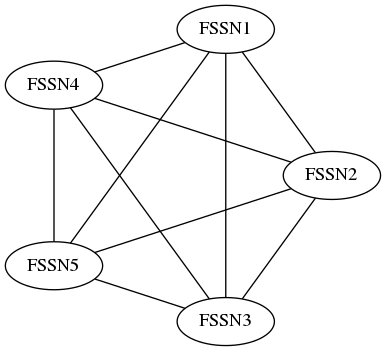

In [38]:
G = pygraphviz.AGraph()
addStations(G)
G.layout(prog='circo')

appColor = {}

for node in G.nodes():
    appG = pygraphviz.AGraph()
    numApps = 1
    for app in appList:
        #---- Check type of a2n matrix entries. If they are a z3 type convert to an int.----
        if type(a2n_df_r.loc[app, node]) ==z3.RatNumRef:
            val = (a2n_df_r.loc[app, node]).as_fraction()
        else:
            val = a2n_df_r.loc[app, node]
            #---COLOR APPS UNIQUELY---
            if val == 1:
                if app in appColor:
                    pass
                    color = appColor[app]
                else:
                    pass
                    color = 65+10*numApps
                    appColor[app] = color
                #---Add appnodes their edges to the station node---
                appG.add_node(app+node)
                #appG.add_node(app+node, attr_dict=dict(rpa_df.loc[:, app]), color=color)
                appG.add_edge(node, app+node) #adding the edge also adds the node
            numApps += 1
    appG.layout()


print(G)
print(appG)
print(G.subgraph(appG))

pprint.pprint(G.nodes())
Image(G.draw(format='png'))

In [19]:
def placeApps(G, a2n_df_r):
    appColor = {}
    for node in nodeList:
        #print("\n before app Graph Edges:")
        #pprint.pprint(G.edges())
        appG = nx.Graph()
        numApps = 1 #used to increment color when there is a new app
        
        for app in appList:
            #---- Check type of a2n matrix entries. If they are a z3 type convert to an int.----
            if type(a2n_df_r.loc[app, node]) ==z3.RatNumRef:
                val = (a2n_df_r.loc[app, node]).as_fraction()
            else:
                val = a2n_df_r.loc[app, node]
            #---COLOR APPS UNIQUELY---
            if val == 1:
                if app in appColor:
                    color = appColor[app]
                else:
                    color = 65+10*numApps
                    appColor[app] = color
                #---Add appnodes their edges to the station node---
                appG.add_node(app+node, attr_dict=dict(rpa_df.loc[:, app]), color=color)
                appG.add_edge(node, app+node) #adding the edge also adds the node
            numApps += 1
        #---Place apps---            
        app_pos = nx.circular_layout(appG, scale=.05, center=G.node[node]['pos'])
        nx.set_node_attributes(appG, 'pos', app_pos)
        #---combine app graph with station graph            
        G = nx.compose(appG, G) # Attributes from H take precedent over attributes from G.             
        #print("\n node %s" %node)
        #pprint.pprint(G.nodes(data=True), width=120)
    return G